In [37]:
import numpy as np
import matplotlib.pyplot as plt
import gcmotion as gcm

# for debugging, can be removed
gcm.utils.reload()

plt.style.use("ggplot")
plt.rcParams["figure.dpi"] = 150

### Variables and Equations

The purpose of this tool is to calculate the orbit of different particles in a toroidal magnetic field $\vec B$ with large aspect ratio (LAR) and constant $g,I$. The orbits are calculated by solving Hamiltons equations as presented in "The theory of toroidally confined plasmas" by R. B. White,with a 4th order Runge-Kutta method

Our dynamical variables are  $\theta, P_\theta, \zeta, P_\zeta$ and $ \rho_{||}$, and they are governed through Hamilton's equations:

$$
\dot \theta = \dfrac{1}{D}\rho_{||}B^2 +\dfrac{g}{D}\bigg[ -(\mu+\rho^2_{||}B)\bigg(\dfrac{q}{\sqrt{2\psi}}\cos(\theta)\bigg)  + \dfrac{\partial \Phi}{\partial \psi_p}\bigg]
$$

$$
\dot \psi_p = \dfrac{\dot\psi}{q(\psi)} = -\dfrac{g}{D}\bigg[(\mu + \rho_{||}^2B)\sqrt{2\psi}\sin(\theta) + \dfrac{\partial \Phi}{\partial \theta}\bigg]
$$

$$
\dot \rho_{||} = -\dfrac{1}{D}\bigg[(\mu + \rho_{||}^2B)\sqrt{2\psi}\sin(\theta) + \dfrac{\partial \Phi}{\partial \theta} \bigg]
$$

$$
\dot \zeta = \dfrac{\rho_{||}B^2}{D} - \dfrac{I}{D}\bigg[ -(\mu+\rho^2_{||}B)\bigg(\dfrac{q}{\sqrt{2\psi}}\cos(\theta)\bigg)  + \dfrac{\partial \Phi}{\partial \psi_p}\bigg]
$$

where:  $\quad B = 1 - \sqrt{2\psi}\cos(\theta)$

We can then calculate the canonical momenta as $P_\theta = \psi + \rho_{||}I$ and $P_\zeta = \rho_{||} g -\psi_p$

### Part 1: Particle Initialization and obrit calculation

In this cell we can create multiple particles independently. By setting cwp (current working particle), we chose the particle to proceed. That way we can keep all previous particles in memory and switch cwp at any point.

First we set up the Tokamak configuration, and the particle's initial conditions

In [38]:
R, a    = 6.2, 2 # Major/Minor Radius in [m]
q       = gcm.qfactor.Hypergeometric(R, a)
Bfield  = gcm.bfield.LAR(i = 0, g = 1, B0 = 5)
Efield  = gcm.efield.Radial(R, a, q, Ea = 0, minimum = 0.98, waist_width=50)

# Create Particle
species = "p"
mu = 10e-5 # Magnetic moment
theta0 = np.pi/3
psi0 = 0.4513# times psi_wall
z0 = np.pi
Pz0 = -0.03
tspan = np.linspace(0, 100000, 50000) # t0, tf, steps

init_cond = [theta0, psi0, z0, Pz0]

#Particle Creation
Electron1 = gcm.Particle(species, mu, init_cond, tspan, R, a, q, Bfield, Efield)
cwp = Electron1
cwp.run()

Constants of motion:
	Particle Energy (normalized):	E  = 1.270977e-04
	Particle Energy (eV):		E  = 8.617700e+03 eV
	Particle Energy (J):		E  = 1.380708e-15 J
	Toroidal Momenta:		Pζ = -0.03

Other Quantities:
	Particle of Species:		"p"
	Orbit Type:			Cannot calculate (Electic field is non-zero)
	Major Radius:			R = 6.2 meters
	Minor Radius:			α = 2 meters
	Toroidal Flux at wall:		ψ = 0.0520291
	Time unit:			ω = 4.789417e+08 Hz 
	Energy unit:			E = 1.474845e-08 J 

Orbit calculation time: 0.1836s.


### Part 2: Plots

In [39]:
#cwp.plot.tokamak_profile(zoom = [0.2, 1.1])

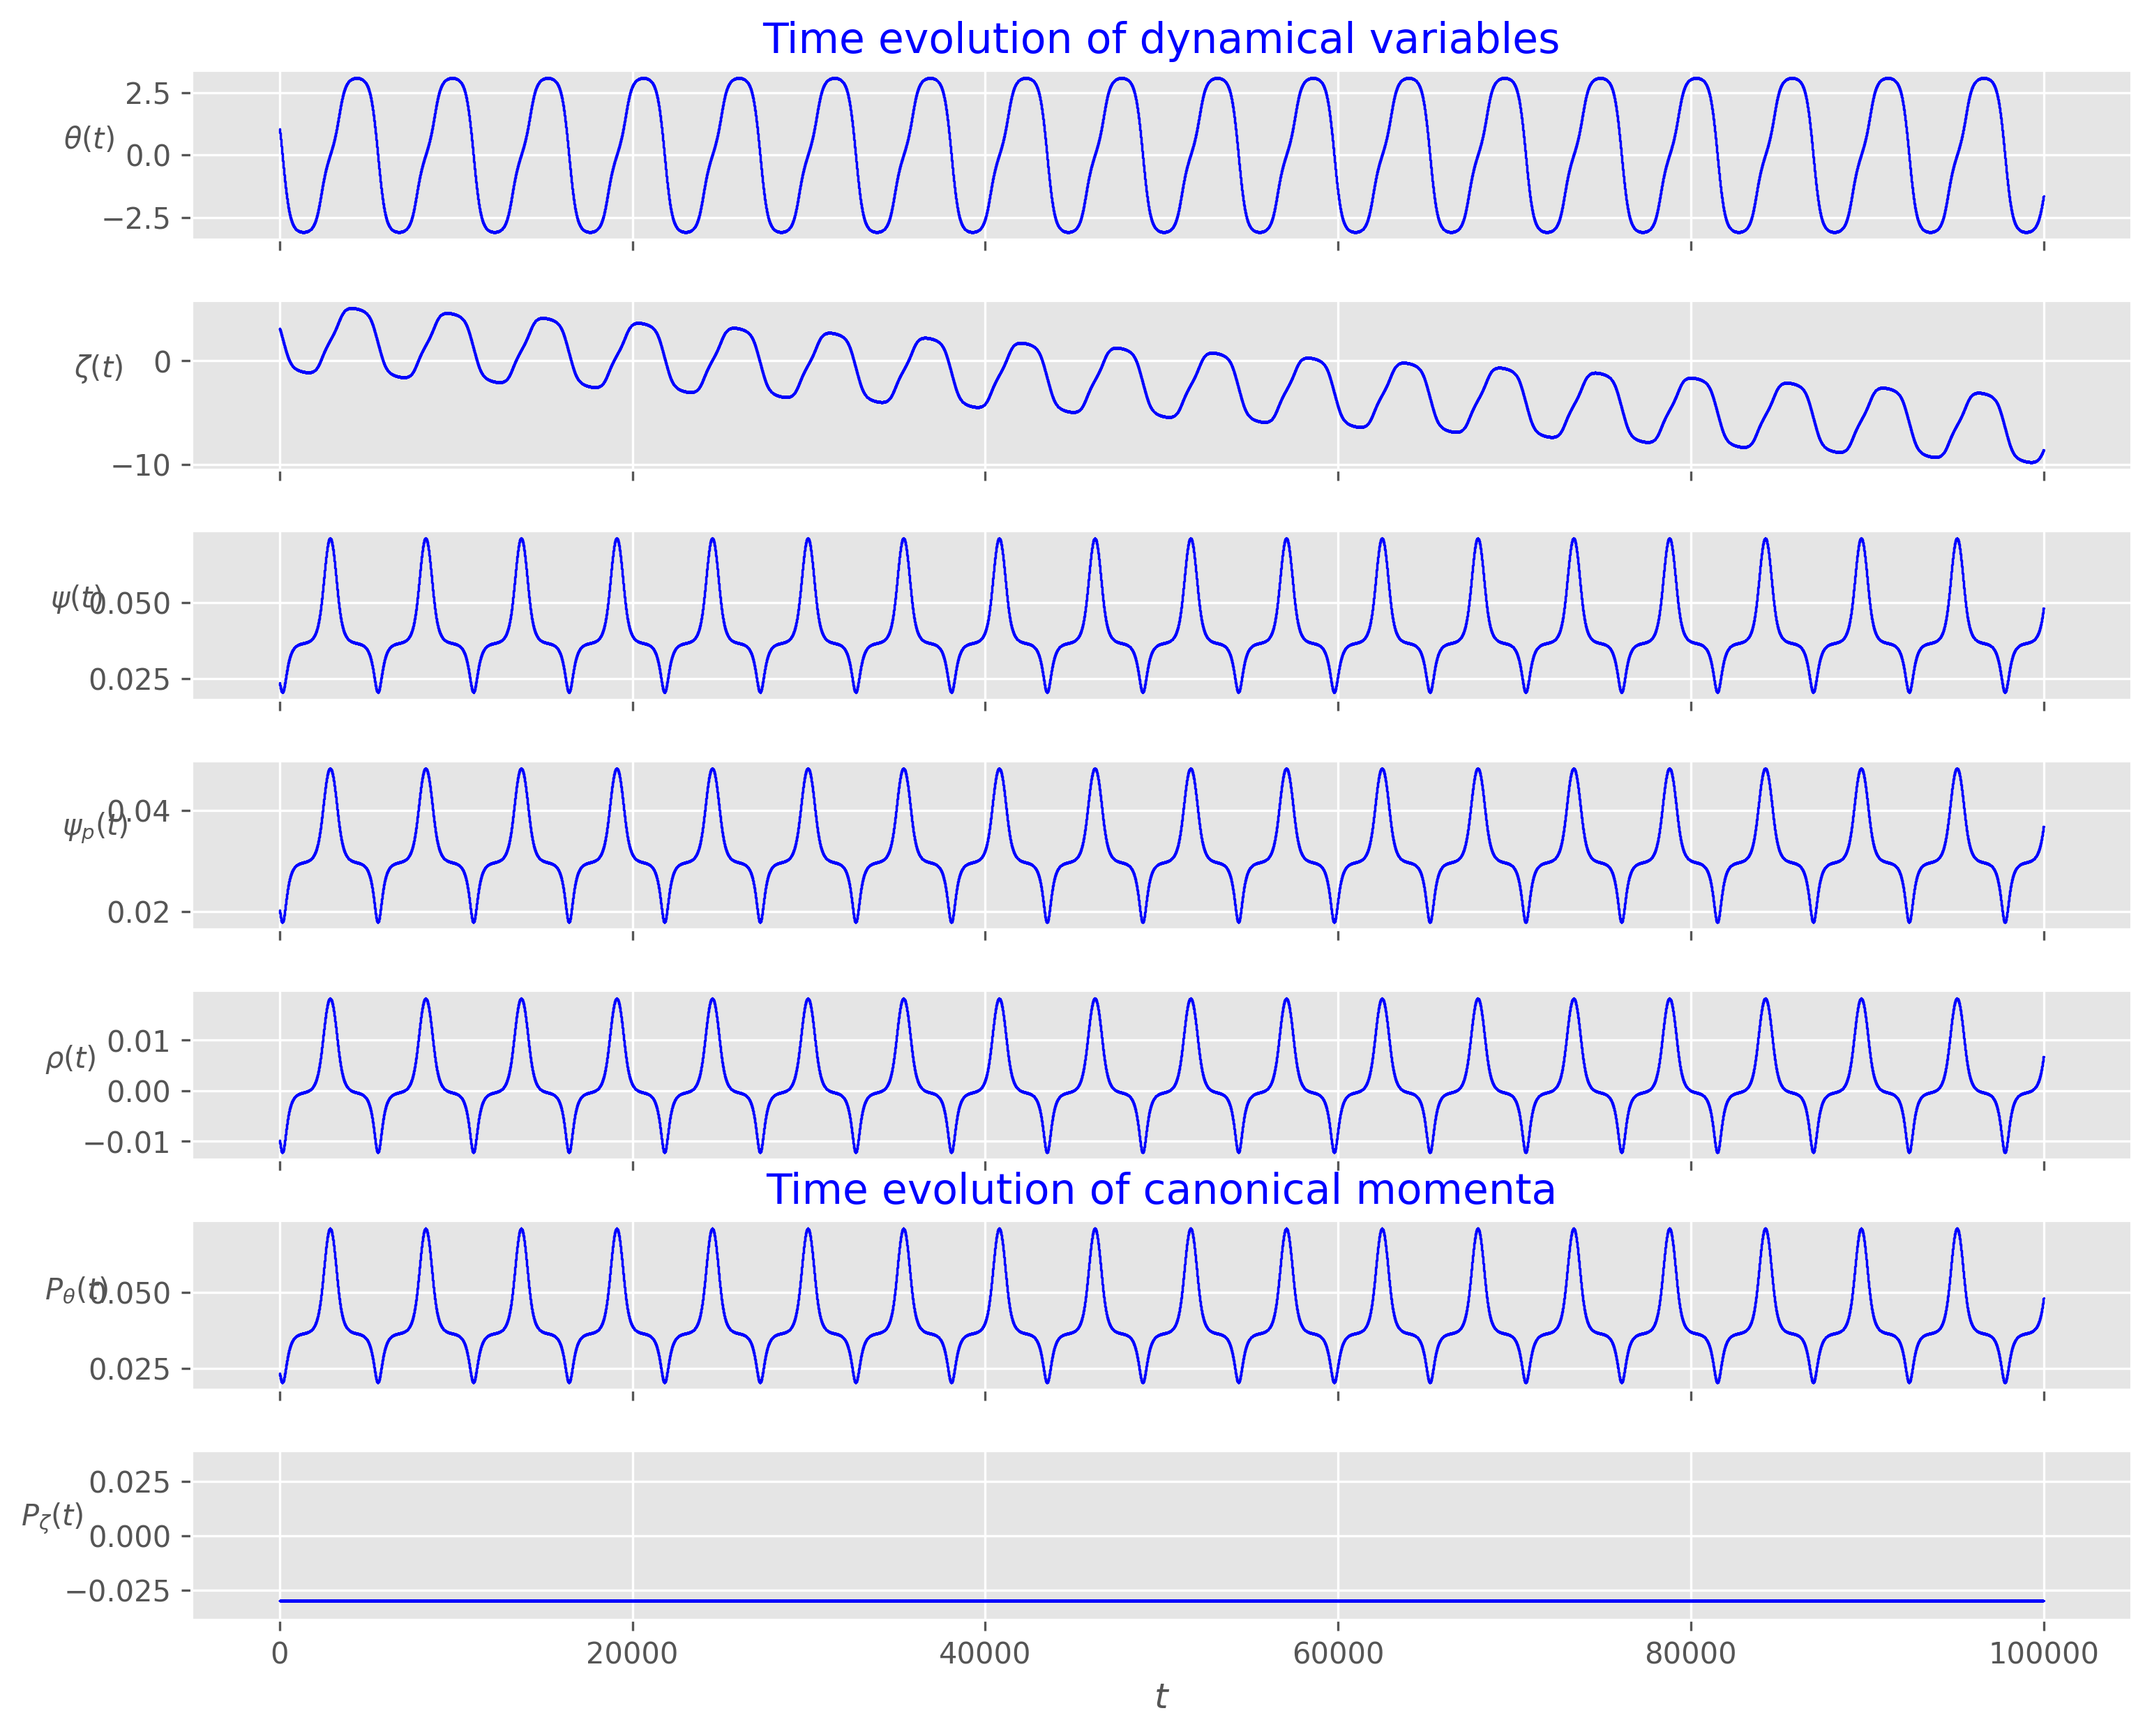

In [40]:
cwp.plot.time_evolution(percentage =100)

### Energy Contour Plots

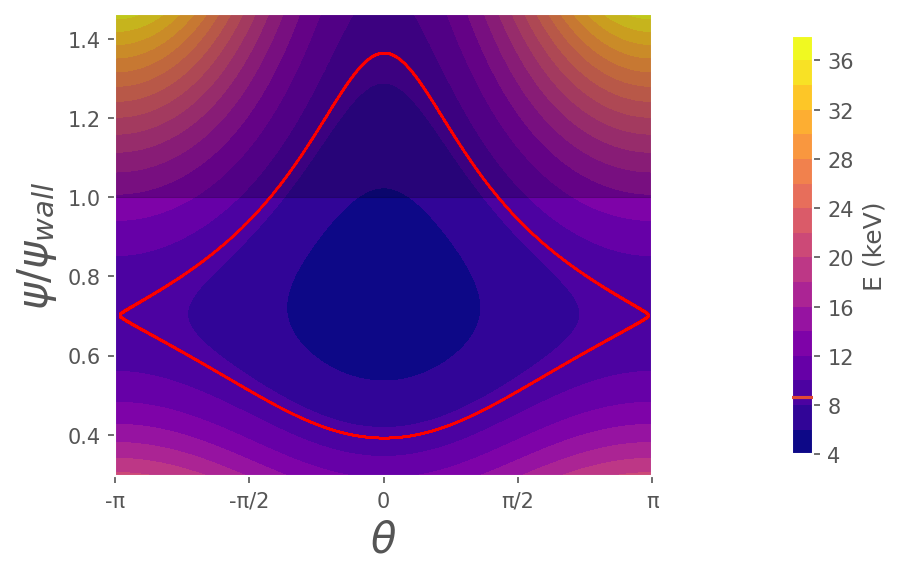

In [41]:
cwp.plot.contour_energy(
    theta_lim = [-np.pi ,np.pi], psi_lim = "auto", 
    plot_drift=True, contour_Phi = True, units = "keV", levels = 20
);

## Orbit types parabolas

### Parabolas Derivation

The two left parabolas are defined in White as:

$$
\dfrac{(P_\zeta + \psi_{wall})^2B^2_{min}}{2g^2(\psi_{wall})}+\mu B_{min}+\Phi_{wall}-E=0
$$

We can re-order the terms as such:

$$
\bigg(\dfrac{\mu B_0}{E} \bigg) = - \dfrac{B_{min}B_0\psi^2_{wall}}{2g^2E}
\bigg(\dfrac{P_\zeta}{\psi_{wall}}\bigg)^2 - 
\dfrac{B_{min}B_0\psi^2_{wall}}{g^2E}\bigg(\dfrac{P_\zeta}{\psi_{wall}}\bigg)-
\dfrac{B_{min}B_0\psi^2_{wall}}{2g^2E} + \dfrac{B_0}{B_{min}}
\bigg(1-\dfrac{\Phi_{wall}}{E}\bigg) 
$$

where $E = \mu B_{min}+\Phi_{wall}$

***

Similarly, for the right parabola, we have:

$$
\bigg(\dfrac{\mu B_0}{E} \bigg) = - \dfrac{B_0^2\psi^2_{wall}}{2g^2E}\bigg(\dfrac{P_\zeta}{\psi_{wall}}\bigg)^2 + 1 - \dfrac{\Phi_0}{E}
$$

where $E = \mu B_{0}+\Phi_{0}$

***

As for the Trapped-Passing Boundary:

$$
\bigg(\dfrac{\mu B_0}{E} \bigg) = \dfrac{1}{1\pm\sqrt{-2\psi_{wall}\bigg(\dfrac{P_\zeta}{\psi_{wall}}\bigg)}}\bigg(1 - \dfrac{\Phi_0}{E}\bigg)
$$

***

By defining the new variables:

$$
x=\bigg(\dfrac{P_\zeta}{\psi_{wall}}\bigg)\quad,\quad y = \bigg(\dfrac{\mu B_0}{E} \bigg)
$$

we define a parabola $y = \alpha x^2 + \beta x + \gamma$. Now we can easily find the minima/maxima and axis intercepts.

Note: Since $B = 1 - \sqrt{2\psi}\cos\theta \quad$,   $\psi_{wall}$ should be less that 0.5

As for figuring out if the particle is Lost or Confined, we need only to check if its orbit point lies in-between the 2 left parabolas.

### Parabolas Diagram

In [42]:
# cwp.plot.parabolas()
# cwp.plot.orbit_point()

## Torus Poincare map and 3d Torus orbits

In [43]:
# cwp.plot.torus2d(percentage = 100, truescale=True)

In [44]:
# cwp.plot.torus3d(percentage=100, truescale=True, 
#                 white_background=True, hd=False,)

In [45]:
# params = {"percentage": 100, "truescale": True,
#           "min_step": 0.01, "seconds": 300}
# gcm.animate(cwp, params)

## FFT

---------THETA---------
Frequency (from peak-to-peak)		= (5.547e+05 ± 606.7) Hz.
DC bias:				= -0.0003293 rads.
Bias (zeroth frequency)			= 4.9 rads/s.
Filtered(unbiased) signal amplitude	= 3.0910e+00 rads.



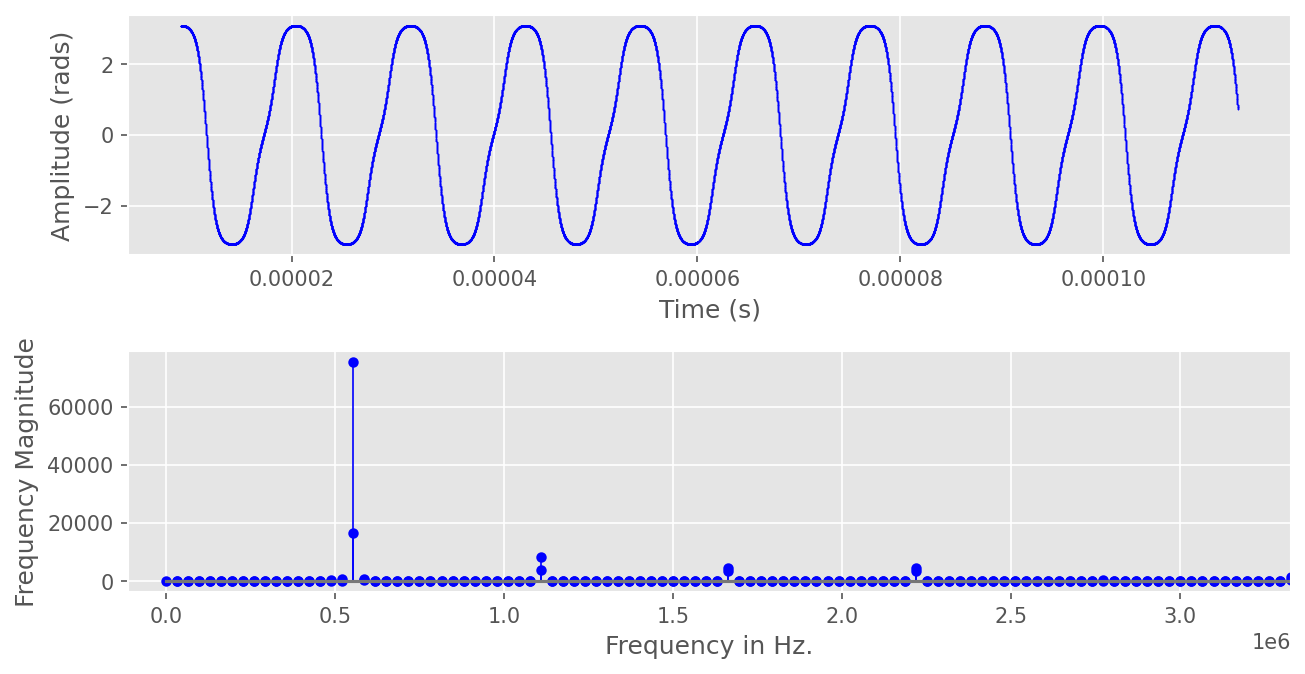

In [46]:
cwp.freq_analysis(angle = "theta", trim = True, normal = False, remove_bias=True)
cwp.plot.fft()

---------ZETA---------
Frequency (from peak-to-peak)		= (5.547e+05 ± 594.6) Hz.
DC bias:				= 2.214 rads.
Bias (zeroth frequency)			= -4.211e+04 rads/s.
Filtered(unbiased) signal amplitude	= 3.2385e+00 rads.



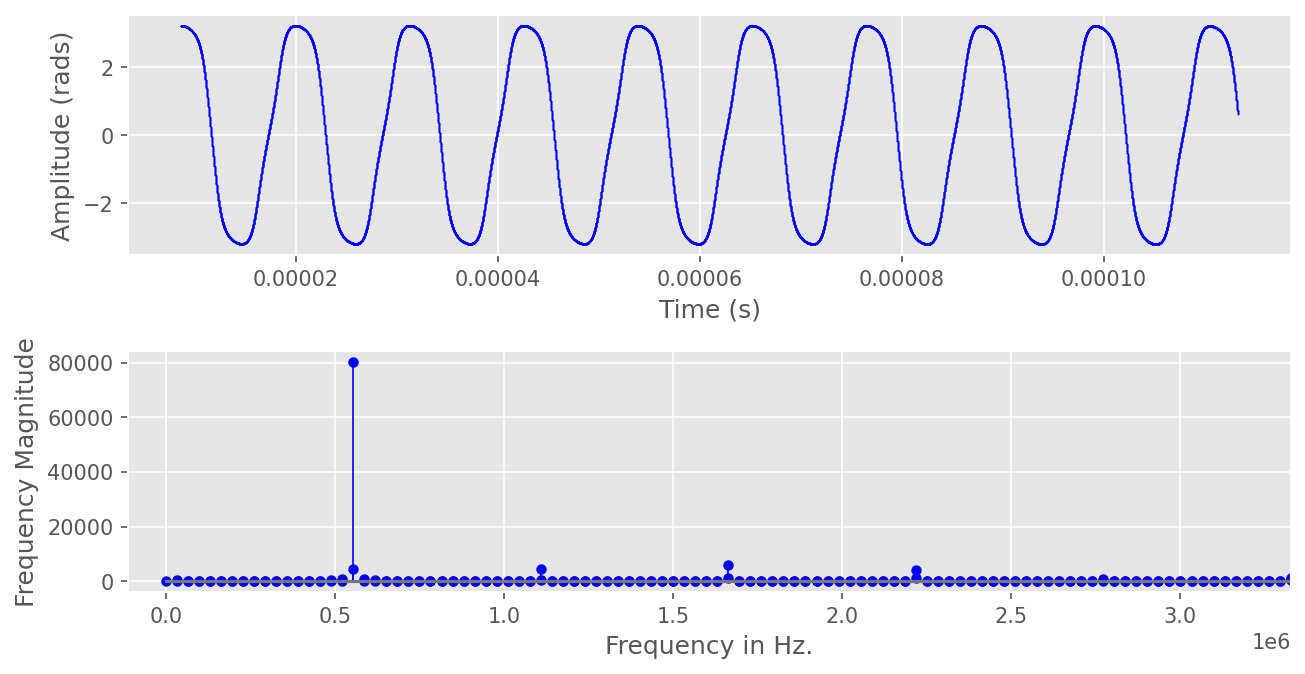

In [47]:
cwp.freq_analysis(angle = "zeta", trim = True, normal = False, remove_bias = True)
cwp.plot.fft()

In [48]:
cwp.q_kinetic()

'Calculated q_kinetic: 0.0759'